=== Colunas numéricas usadas no PCA ===
['elev_av', 'aspect_sin', 'aspect_cos', '1_3y_fir_p', '3_8y_fir_p', '8_ny_fir_p', 'f_load_av', 'sW_1m_av', 'sW_3m_av', 'sW_7_av', 'sW_28_av', 'sW_100_av', 'sW_289_av', 't_2m_C_av', 'd_2m_C_av', 'rh_2m_av', 'VPD_Pa_av', 'sP_hPa_av', 'gp_m2s2_av', 'dfmc_av', 'HDW_av', 'FWI_12h_av', 'DC_12h_av', 'FFMC_12h_a', 'wv10_kh_av', 'wsin10_av', 'wcos10_av', 'wv100_k_av', 'wsin100_av', 'wcos100_av', 'Recirc', 'CircVar', 't_950_av', 't_850_av', 't_700_av', 't_500_av', 't_300_av', 'rh_950_av', 'rh_850_av', 'rh_700_av', 'rh_500_av', 'rh_300_av', 'wv_950_av', 'wv_850_av', 'wv_700_av', 'wv_500_av', 'wv_300_av', 'wsi_950_av', 'wco_950_av', 'wsi_850_av', 'wco_850_av', 'wsi_700_av', 'wco_700_av', 'wsi_500_av', 'wco_500_av', 'wsi_300_av', 'wco_300_av', 'vwv_950_av', 'vwv_850_av', 'vwv_700_av', 'vwv_500_av', 'vwv_300_av', 'gp_950_av', 'gp_850_av', 'gp_700_av', 'gp_500_av', 'gp_300_av', 'gT_s_9_av', 'gT_9_8_av', 'gT_8_7_av', 'gT_7_5_av', 'gT_5_3_av', 'wSv_9_av', 'wSsin_

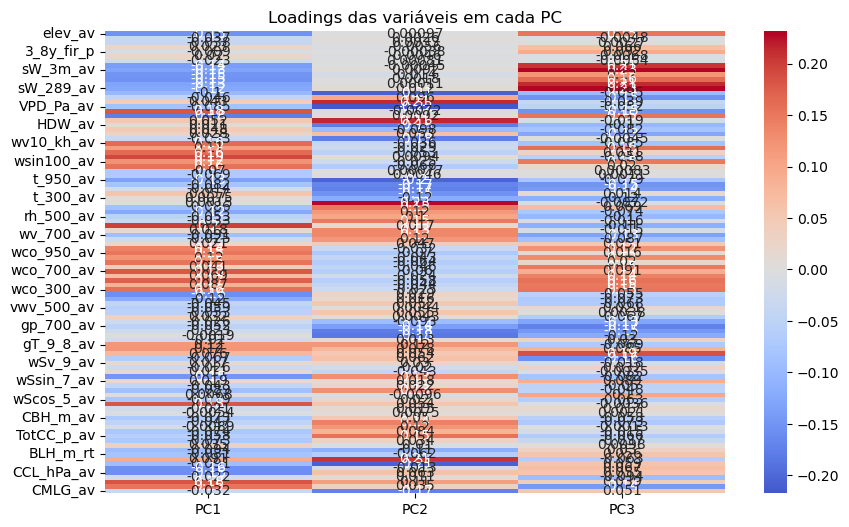

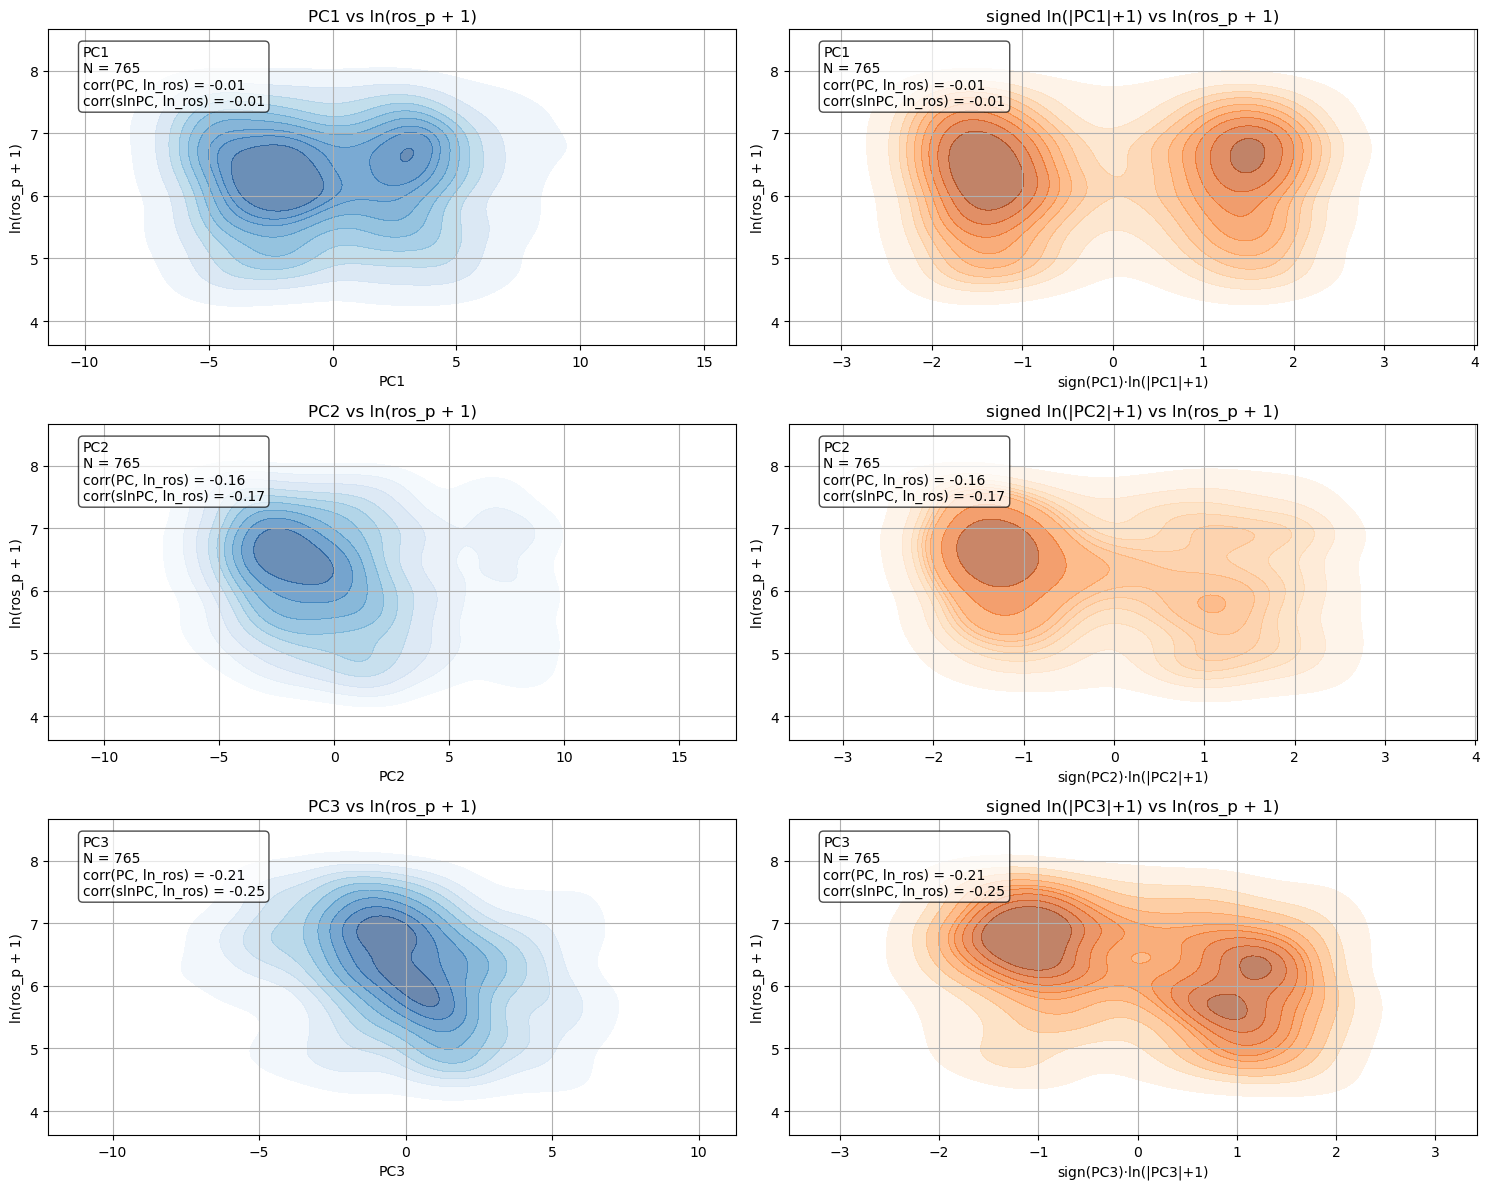

In [16]:
# =========================================================
# PCA E ANÁLISE DE FIRE BEHAVIOR - VERSÃO KDE
# =========================================================
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# =========================================================
# 1. LOAD AND PREPARE DATA
# =========================================================
shp_path = r"..\..\Data\Processed\PT-FireSprd_v2.1\L2_FireBehavior\PT-FireProg_v2.1_L2_model_Outubro.shp"
gdf = gpd.read_file(shp_path)

# Remover colunas desnecessárias
gdf = gdf.drop(columns=[
    'inidoy', 'enddoy', 'ros_p_lg1',
    'duration_p', 'f_start', 'geometry'
])

# Converter variáveis categóricas
categorical_vars = ["fuel_model", "landform", "land_use", "Haines_av"]
for col in categorical_vars:
    gdf[col] = gdf[col].astype(str).astype("category")

# =========================================================
# 2. PREPARE DATA FOR PCA
# =========================================================
numeric_cols = gdf.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'ros_p' in numeric_cols:
    numeric_cols.remove('ros_p')  # ros_p NÃO entra no PCA

print("=== Colunas numéricas usadas no PCA ===")
print(numeric_cols)

X = gdf[numeric_cols].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =========================================================
# 3. PCA COM 3 COMPONENTES
# =========================================================
n_components = 3
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

print("\n=== Variância explicada ===")
for i, v in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {v:.3f}")

# =========================================================
# 4. LOADINGS
# =========================================================
loadings = pd.DataFrame(
    pca.components_.T,
    index=numeric_cols,
    columns=[f'PC{i+1}' for i in range(n_components)]
)

print("\n=== Loadings (cargas) ===")
print(loadings)

# =========================================================
# 4.1 TOP 20 VARIÁVEIS POR PC
# =========================================================
print("\n=== TOP 20 VARIÁVEIS POR COMPONENTE PRINCIPAL ===")

for pc in loadings.columns:
    print(f"\n{pc} – Top 20 variáveis (|loading|):")
    top20_pc = (
        loadings[pc]
        .abs()
        .sort_values(ascending=False)
        .head(20)
    )
    for var in top20_pc.index:
        print(f"  {var:<30s} {loadings.loc[var, pc]: .3f}")

# =========================================================
# 4.2 TOP 20 VARIÁVEIS GLOBAIS
# =========================================================
loadings['total_abs'] = loadings.abs().sum(axis=1)
print("\n=== TOP 20 VARIÁVEIS (contribuição total nos 3 PCs) ===")
print(loadings['total_abs'].sort_values(ascending=False).head(20))

# Variáveis fracas
weak_vars = loadings.drop(columns='total_abs')[
    (loadings.drop(columns='total_abs').abs() < 0.2).all(axis=1)
]
print("\n=== Variáveis que não se encaixam em nenhum PC (|loading| < 0.2) ===")
print(weak_vars.index.tolist())

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    loadings.drop(columns='total_abs'),
    annot=True,
    cmap='coolwarm',
    center=0
)
plt.title('Loadings das variáveis em cada PC')
plt.show()

# =========================================================
# 5. ln(ros_p + 1)
# =========================================================
gdf['ln_ros_p1'] = np.log1p(gdf['ros_p'])

for i in range(n_components):
    gdf[f'PC{i+1}'] = X_pca[:, i]

# =========================================================
# 6. KDE FINAL: ln(ros_p+1) vs PC e signed ln(|PC|+1)
# =========================================================
plt.figure(figsize=(15, 12))

for i in range(n_components):
    pc = f'PC{i+1}'
    pc_vals = gdf[pc]
    signed_log_pc = np.sign(pc_vals) * np.log1p(np.abs(pc_vals))
    ln_ros = gdf['ln_ros_p1']

    corr_pc = np.corrcoef(pc_vals, ln_ros)[0, 1]
    corr_signed = np.corrcoef(signed_log_pc, ln_ros)[0, 1]

    stats = (
        f"{pc}\n"
        f"N = {len(ln_ros)}\n"
        f"corr(PC, ln_ros) = {corr_pc:.2f}\n"
        f"corr(slnPC, ln_ros) = {corr_signed:.2f}"
    )

    # KDE PC
    plt.subplot(n_components, 2, 2*i + 1)
    sns.kdeplot(x=pc_vals, y=ln_ros, fill=True, cmap='Blues', alpha=0.6)
    plt.xlabel(pc)
    plt.ylabel('ln(ros_p + 1)')
    plt.title(f'{pc} vs ln(ros_p + 1)')
    plt.text(0.05, 0.95, stats, transform=plt.gca().transAxes,
             va='top', bbox=dict(boxstyle='round', fc='white', alpha=0.7))
    plt.grid(True)

    # KDE signed log PC
    plt.subplot(n_components, 2, 2*i + 2)
    sns.kdeplot(x=signed_log_pc, y=ln_ros, fill=True, cmap='Oranges', alpha=0.6)
    plt.xlabel(f'sign({pc})·ln(|{pc}|+1)')
    plt.ylabel('ln(ros_p + 1)')
    plt.title(f'signed ln(|{pc}|+1) vs ln(ros_p + 1)')
    plt.text(0.05, 0.95, stats, transform=plt.gca().transAxes,
             va='top', bbox=dict(boxstyle='round', fc='white', alpha=0.7))
    plt.grid(True)

plt.tight_layout()
plt.show()
